# Date : 24-09-2022
# Missing Value Handling 
*   KNNImputer
*   Iterative Imputer 
*   Simple Imputer
*   Data set: Diabeteis



In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import scipy.stats as stats
import seaborn as sn
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute  import KNNImputer

# Read Raw Data

In [3]:
data=pd.read_csv("/content/diabetes.csv")

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# Speparate Various Variable types

In [7]:
categorical_feat=[feat for feat in data.columns if data[feat].dtype=='O' and feat != 'Outcome']  
categorical_feat

[]

In [9]:
discrete_feat = [feat for feat in data.columns if data[feat].dtype != 'O' 
                  and feat != 'Outcome' and data[feat].nunique() < 10]
discrete_feat 

[]

In [10]:
Continuous_feat = [feat for feat in data.columns if data[feat].dtype != 'O' 
                  and feat != 'Outcome' and feat not in discrete_feat ]
Continuous_feat

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

# All the features are Continuous Features

In [32]:
data_dict={}
missing_list=[]
for feat in Continuous_feat:
  if len(data[data[feat]==0]) >0:
   data_dict[feat]=(len(data[data[feat]==0])/len(data))* 100
   missing_list.append(feat)
 

In [34]:
data_dict,missing_list

({'Pregnancies': 14.453125,
  'Glucose': 0.6510416666666667,
  'BloodPressure': 4.557291666666666,
  'SkinThickness': 29.557291666666668,
  'Insulin': 48.69791666666667,
  'BMI': 1.4322916666666665},
 ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI'])

In [21]:
data.skew()

Pregnancies                 0.901674
Glucose                     0.173754
BloodPressure              -1.843608
SkinThickness               0.109372
Insulin                     2.272251
BMI                        -0.428982
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Outcome                     0.635017
dtype: float64

In [27]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [29]:
data.corr().T

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [31]:
ndata = data.copy(deep = True)

In [35]:
ndata[missing_list] = ndata[missing_list].replace(0, np.NaN)

In [41]:
ndata.isnull().mean()

Pregnancies                 0.144531
Glucose                     0.006510
BloodPressure               0.045573
SkinThickness               0.295573
Insulin                     0.486979
BMI                         0.014323
DiabetesPedigreeFunction    0.000000
Age                         0.000000
Outcome                     0.000000
dtype: float64

# Distplot before Imputation

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(14,14))
fig.suptitle("Distribution Plot", y=0.92, fontsize='x-large')
fig.tight_layout(pad=4.0)

for i,j in enumerate(ndata.columns[:-1]):
    sn.distplot(ndata[j], ax=axes[i//2, i%2])

# Imputation strategy :KNNImputer

In [43]:
imputer=KNNImputer(n_neighbors=5, 
    weights='distance', 
    metric='nan_euclidean', 
    add_indicator=False, 
    )


In [46]:
ndata_KNN=ndata.copy()

In [47]:
wndata_KNN=imputer.fit_transform(ndata_KNN)

In [49]:
wndata_KNN=pd.DataFrame(wndata_KNN,columns=ndata.columns)

In [50]:
wndata_KNN.isnull().mean()

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


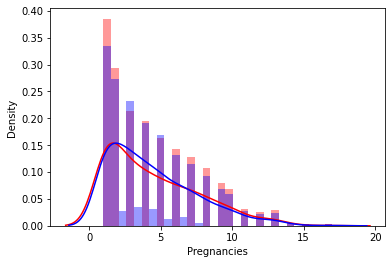

In [59]:
sn.distplot(ndata['Pregnancies'], kde = True, color ='red', bins = 30)
sn.distplot(wndata_KNN['Pregnancies'], kde = True, color ='blue', bins = 30)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


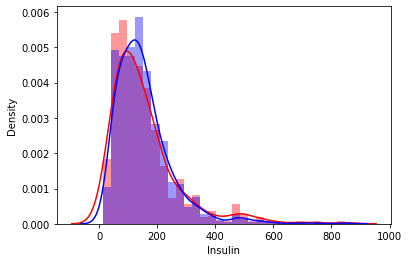

In [65]:
sn.distplot(ndata['Insulin'], kde = True, color ='red', bins = 30)
sn.distplot(wndata_KNN['Insulin'], kde = True, color ='blue', bins = 30)

# Imputation strategy :Iterative Imputer
Iterative Imputation refers to a process where each feature is modeled as a function of the 
other features. Prior imputed values are used to predict subsequent features in a sequential 
manner (ref).Iterative Imputation can be done to impute missing data with the use of different
estimators. The default estimator used when doing scikit-learn's IterativeImputer is the 
`BayesianRidge()` estimator.

In [66]:
imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)

In [89]:
wndata_bayes=pd.DataFrame(imputer.fit_transform(ndata),columns=ndata.columns)

In [90]:
wndata_bayes['Insulin'].skew(),ndata['Insulin'].skew()

(2.132575603484628, 2.166463843812443)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


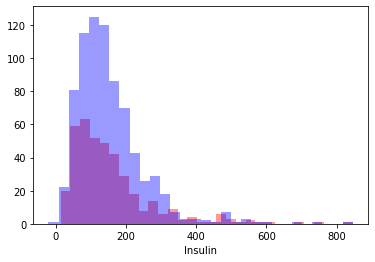

In [103]:
sn.distplot(ndata['Insulin'], kde = False, color ='red', bins = 30)
sn.distplot(wndata_bayes['Insulin'], kde = False, color ='blue', bins = 30)

# Iterative Imputer: DecisionTreeRegressor

In [84]:
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0),
    max_iter=500,
    random_state=0)


In [ ]:
wndata_DecTRE=imputer_nonLin.fit_transform(ndata)

In [86]:
wndata_DecTRE=pd.DataFrame(wndata_DecTRE,columns=ndata.columns)

In [88]:
wndata_DecTRE['Insulin'].skew(),ndata['Insulin'].skew()

(2.2574241592654216, 2.166463843812443)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


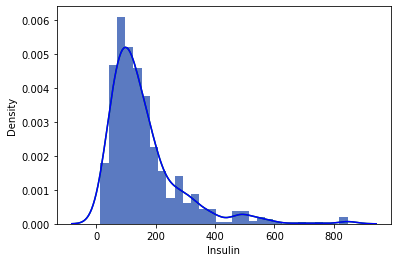

In [100]:
sn.distplot(wndata_DecTRE['Insulin'], kde = True, color ='green', bins = 30)
sn.distplot(wndata_DecTRE['Insulin'], kde = True, color ='blue', bins = 30)

# Iterative Imputor: ExtraRegressor

In [106]:
imputer_missForest = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=0),
    max_iter=100,
    random_state=0)

In [107]:
wndata_ETR=pd.DataFrame(imputer_missForest.fit_transform(ndata),columns=ndata.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [108]:
wndata_ETR['Insulin'].skew(),ndata['Insulin'].skew()

(2.162084549959856, 2.166463843812443)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


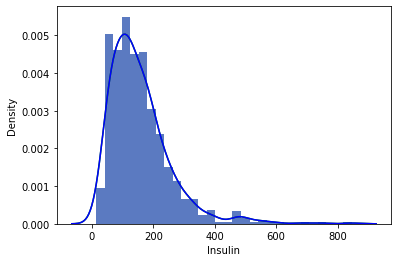

In [99]:
sn.distplot(wndata_ETR['Insulin'], kde = True, color ='green', bins = 30)
sn.distplot(wndata_ETR['Insulin'], kde = True, color ='blue', bins = 30)

In [101]:
ndata.corr().T

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.166329,0.285013,0.167298,0.104081,0.128207,-0.006459,0.550525,0.268218
Glucose,0.166329,1.000000,0.223192,0.228043,0.581186,0.232771,0.137246,0.267136,0.494650
BloodPressure,0.285013,0.223192,1.000000,0.226839,0.098272,0.289230,-0.002805,0.330107,0.170589
SkinThickness,0.167298,0.228043,0.226839,1.000000,0.184888,0.648214,0.115016,0.166816,0.259491
Insulin,0.104081,0.581186,0.098272,0.184888,1.000000,0.228050,0.130395,0.220261,0.303454
BMI,0.128207,0.232771,0.289230,0.648214,0.228050,1.000000,0.155382,0.025841,0.313680
DiabetesPedigreeFunction,-0.006459,0.137246,-0.002805,0.115016,0.130395,0.155382,1.000000,0.033561,0.173844
Age,0.550525,0.267136,0.330107,0.166816,0.220261,0.025841,0.033561,1.000000,0.238356
Outcome,0.268218,0.494650,0.170589,0.259491,0.303454,0.313680,0.173844,0.238356,1.000000


# Simple Imputer